In [1]:
import networkx as nx
import numpy as np
import pandas as pd  
from networkie.gen import Custom
import matplotlib.pyplot as plt

load = Custom.LoadFromFile()
g =load.from_in_class_network("dataset/In-class_network.txt")
df = pd.read_table("dataset/In-class_network.txt")

Name: 
Type: Graph
Number of nodes: 75
Number of edges: 109
Average degree:   2.9067
Edgelist txt data successfully loaded into a networkx Graph!


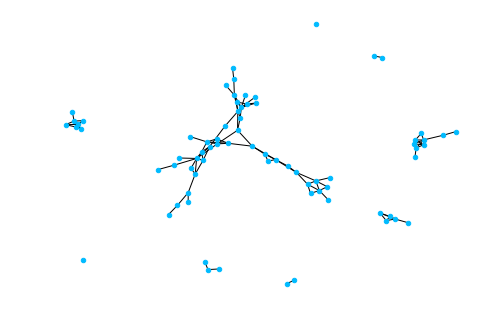

In [2]:
nx.draw(g, node_color = '#00BBFF', node_size = 20, with_labels = False)
plt.show()


In [13]:
import numpy as np

# b.(1) the number
number = nx.number_of_nodes(g)
print("The number of nodes: %d" % (number))
# b.(2) the number of edges
edge = nx.number_of_edges(g)
print("The number of edges: %d" % (edge))
# b.(3) the number of Average degree
Average_degrees = 2*edge/number
print("Average degree:",Average_degrees)
# b.(4) the number of Average path

print('Average path : ')


# b.(5) the the size of the largest connected component
largest = max(nx.connected_components(g), key=len)
print("The size of the largest connected component :" ,len(largest))

The number of nodes: 75
The number of edges: 109
Average degree: 2.9066666666666667
Average path : 
The size of the largest connected component : 45


In [4]:
#e/emax
e_max=(len(df['ID'])*(len(df['ID'])-1))/2    #56為資料ID欄位的總長
division_emax=g.size()/e_max
print(division_emax)

0.07077922077922078


c:\python35-32\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


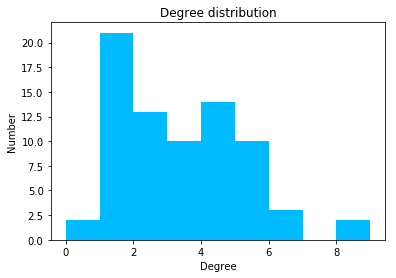

In [5]:
from networkie.utils import Measures
node = Measures.Node()
g_degree = node.degree_dist(g)

 
%matplotlib inline
g_degree = np.array(g_degree)
y = np.bincount(g_degree)
x = np.arange(max(g_degree)+1)
plt.hist(g_degree, 9, normed=0, facecolor='#00BBFF',histtype='bar')
plt.title('Degree distribution')
plt.xlabel("Degree")
plt.ylabel('Number')

plt.show()

In [6]:
from networkie.utils import Measures
answer_triangle = Measures.compute_num_triangles(g)
print("The total triangle of the graph " ,(answer_triangle))

The total triangle of the graph  52.0
